In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, auc, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from IPython.display import display
from xgboost import XGBClassifier
from scipy import stats
from sklearn.base import clone

## Wprowadzenie i opis wybranego problemu, opis zbioru danych.

W projekcie wykorzystano zbiór danych Adult dostępny w repozytorium UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/2/adult).
Dane pochodzą ze spisu ludności Stanów Zjednoczonych 1994 roku i służą do analizy czynników wpływających na poziom dochodów osób dorosłych.

Celem projektu jest predykcja, czy roczny dochód osoby przekracza 50 tys. USD na podstawie cech demograficznych i zawodowych. Jest to problem klasyfikacji binarnej.

Oryginalny zbiór danych ma 48 842 wiersze oraz 15 zmiennych:

- **age** – wiek
- **workclass** – typ zatrudnienia
- **fnlwgt** – waga statystyczna przypisana do obserwacji
- **education** – poziom wykształcenia
- **education-num** – liczbowy odpowiednik poziomu wykształcenia
- **marital-status** – stan cywilny
- **occupation** – wykonywany zawód
- **relationship** – relacja w gospodarstwie domowym
- **race** – rasa
- **sex** – płeć
- **capital-gain** – dochód z inwestycji kapitałowych
- **capital-loss** – strata kapitałowa
- **hours-per-week** – liczba godzin pracy tygodniowo
- **native-country** – kraj pochodzenia
- **income** – zmienna docelowa określająca, czy dochód przekracza 50 tys. USD (`>50K`) czy nie (`<=50K`)

## Dataset preprocessing

In [2]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
#print(adult.metadata) 
# variable information 
#print(adult.variables) 

In [3]:
print(X.shape, y.shape)

(48842, 14) (48842, 1)


In [4]:
# skleimy dane w jeden dataset
dataset = pd.concat([X, y], axis=1)
dataset.shape

(48842, 15)

In [5]:
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
# Podstawowe statystyki dla zmiennych kategorialnych
dataset.describe(include=["O"])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,47879,48842,48842,47876,48842,48842,48842,48568,48842
unique,9,16,7,15,6,5,2,42,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


W zbiorze danych dominują osoby pracujące w sektorze prywatnym, z wykształceniem średnim, pozostające w związku małżeńskim. Większość respondentów to mężczyźni, osoby rasy białej oraz mieszkańcy Stanów Zjednoczonych. Najczęściej występującą kategorią dochodu jest ≤50K.

In [7]:
# Podstawowe statystyki dla zmiennych ciągłych
dataset.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Dla zmiennych ciągłych obliczono podstawowe statystyki opisowe, takie jak średnia, odchylenie standardowe, kwartyle oraz wartości minimalne i maksymalne. Średni wiek respondentów wynosi około 39 lat. Większość osób pracuje około 40 godzin tygodniowo. Zmienne capital-gain oraz capital-loss charakteryzują się silną skośnością – mediana wynosi 0, podczas gdy wartości maksymalne są bardzo wysokie, co wskazuje na obecność nielicznych, lecz istotnych wartości skrajnych. Poziom wykształcenia (education-num) koncentruje się głównie wokół wartości 9–12, co odpowiada wykształceniu średniemu.

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


**Braki danych**

W zbiorze danych zidentyfikowano brakujące wartości, które były oznaczone symbolem „?” lub jako NaN. Wartości „?” zostały zastąpione przez NaN, następnie przeanalizowano liczbę braków danych. Braki występowały w kolumnach workclass (5,73%), occupation (5,75%) oraz native-country (1,75%). Ze względu na stosunkowo niski udział brakujących wartości podjęto decyzję o usunięciu obserwacji zawierających braki danych, co skutkowało redukcją zbioru o około 7,4% rekordów. Następnie usunięto duplikaty. Finalna liczba obserwacji wynosi 45 194 wiersze.

In [9]:
# Wyświetlenie informacji o zmiennych jakościowych - unikalne wartości
for col in dataset.select_dtypes(['object']): 
    print(dataset[col].unique())

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Male' 'Female']
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Tha

In [10]:
# część braków danych jest oznaczona jako '?', zamieniamy je na wartości NaN
dataset.replace('?', np.nan, inplace=True)

In [11]:
# sprawdzamy wartości nullowe
dataset.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [12]:
# procentowy udział braków danych
missing_percent = (dataset.isnull().mean() * 100).round(2)
missing_percent[missing_percent > 0]

workclass         5.73
occupation        5.75
native-country    1.75
dtype: float64

In [13]:
# Procent braków danych jest niski - do 6% dla poszczególnych kolumn. Postanowiono usunąć brakujące wartości.
# W wyniku z całego zbioru usunięto 7.4% obesrwacji (3620 rekordów). 
dataset.dropna(inplace=True)
dataset.shape

(45222, 15)

In [14]:
# Usuwamy duplikaty
print(dataset.shape)
dataset.drop_duplicates(inplace=True)
print(dataset.shape)

(45222, 15)
(45194, 15)


**Feature engineering**

W kolejnym kroku przeprowadziliśmy inżynierię cech.
Zmienną docelową income przekształciliśmy do postaci binarnej:
- 0 (dochód ≤ 50K)
- 1 (dochód > 50K)

Zauważyliśmy, że klasy są niezbalansowane – około 75% obserwacji należy do klasy 0, a 25% do klasy 1.
W związku z tym w procesie modelowania uwzględniliśmy to niezbalansowanie, m.in. poprzez zastosowanie parametru class_weight="balanced".

Następnie połączyliśmy wybrane kategorie w zmiennych 'marital-status' oraz 'occupation', aby ograniczyć liczbę rzadko występujących klas i uprościć strukturę danych.

Na podstawie kolumny 'native-country' utworzyliśmy nową zmienną binarną 'native-country-us', informującą, czy dana osoba pochodzi ze Stanów Zjednoczonych (1 – USA, 0 – inne kraje).

Na końcu usunęliśmy kolumny, które nie były istotne w modelowaniu:
- fnlwgt – jest to waga statystyczna, a nie cecha opisująca osobę,
- education – ponieważ posiadamy jej numeryczny odpowiednik education-num,
- native-country – po utworzeniu nowej zmiennej binarnej.

In [15]:
# Wyświetlenie informacji o zmiennych jakościowych
for col in dataset.select_dtypes(['object']): 
    print(dataset[col].value_counts())
    # armed forces w protective serv, priv-house w other

workclass
Private             33281
Self-emp-not-inc     3795
Local-gov            3100
State-gov            1946
Self-emp-inc         1645
Federal-gov          1406
Without-pay            21
Name: count, dtype: int64
education
HS-grad         14777
Some-college     9890
Bachelors        7565
Masters          2513
Assoc-voc        1958
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           822
Prof-school       785
9th               676
12th              576
Doctorate         544
5th-6th           448
1st-4th           220
Preschool          71
Name: count, dtype: int64
marital-status
Married-civ-spouse       21048
Never-married            14580
Divorced                  6294
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: count, dtype: int64
occupation
Craft-repair         6015
Prof-specialty       6003
Exec-managerial      5982
Adm-clerical         5537
Sales                

In [16]:
# Przekształcamy zmienną income na zmienną binarną
print(dataset['income'].value_counts().sort_index())
dataset['income']= dataset['income'].map(lambda x: 0 if x in ['<=50K','<=50K.'] else 1)
dataset['income'].value_counts() 

#zmienna niezbilansowana: 75% stanowią 0, 25% - 1. W dalszym modelowaniu uwzględniamy to niezbalansowanie (np. poprzez class_weight="balanced").

income
<=50K     22633
<=50K.    11355
>50K       7506
>50K.      3700
Name: count, dtype: int64


income
0    33988
1    11206
Name: count, dtype: int64

In [17]:
#łączymy wybrane kategorie w zmiennych marital-status, occupation

dataset['marital-status'] = dataset['marital-status'].replace({
    'Married-civ-spouse': 'Married',
    'Married-AF-spouse': 'Married',
    'Married-spouse-absent': 'Married'
})

dataset['occupation'] = dataset['occupation'].replace({
    'Armed-Forces': 'Protective-serv',
    'Priv-house-serv': 'Other-service'
})

In [18]:
for col in ['marital-status', 'occupation']: 
    print(dataset[col].value_counts())

marital-status
Married          21632
Never-married    14580
Divorced          6294
Separated         1411
Widowed           1277
Name: count, dtype: int64
occupation
Craft-repair         6015
Prof-specialty       6003
Exec-managerial      5982
Adm-clerical         5537
Sales                5408
Other-service        5035
Machine-op-inspct    2967
Transport-moving     2316
Handlers-cleaners    2045
Farming-fishing      1477
Tech-support         1419
Protective-serv       990
Name: count, dtype: int64


In [19]:
# Zmienne education i education-num
for col in ['education', 'education-num']: 
    print(dataset[col].value_counts())

education
HS-grad         14777
Some-college     9890
Bachelors        7565
Masters          2513
Assoc-voc        1958
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           822
Prof-school       785
9th               676
12th              576
Doctorate         544
5th-6th           448
1st-4th           220
Preschool          71
Name: count, dtype: int64
education-num
9     14777
10     9890
13     7565
14     2513
11     1958
7      1619
12     1507
6      1223
4       822
15      785
5       676
8       576
16      544
3       448
2       220
1        71
Name: count, dtype: int64


In [20]:
# tworzymy kolumnę na podstawie native-country-us
dataset['native-country-us'] = (dataset['native-country'] == 'United-States').astype(int)

In [21]:
# Usuwamy kolumnę fnlwgt, która jest wagą statystyczną przypisaną do obserwacji, nie wnosi bezpośredniej informacji predykcyjnej, 
# usuwamy kolumnę education, ponieważ mamy education_num
# Usuwamy kolumnę native-country, 
dataset.drop(["fnlwgt", 'education','native-country'], axis=1, inplace=True)

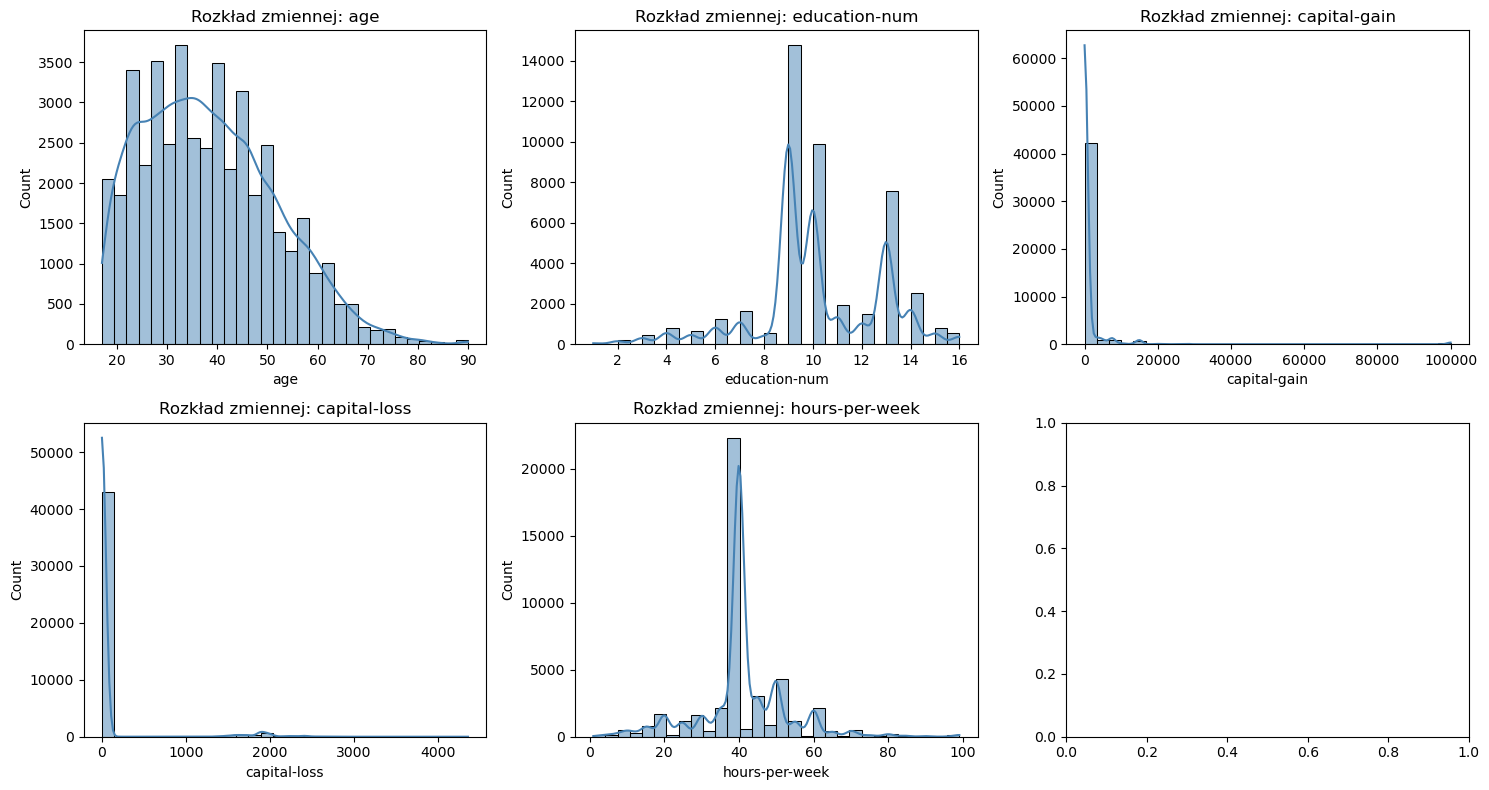

In [22]:
# Rozkłady zmiennych numerycznych
num_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(
        data=dataset,
        x=col,
        bins=30,
        kde=True,
        ax=axes[i],
        color='steelblue'
    )
    axes[i].set_title(f'Rozkład zmiennej: {col}')

plt.tight_layout()
plt.show()

Zmienne capital-gain i capital-loss charakteryzują się silnie skośnym rozkładem z dużą liczbą zer, co jest typowe dla danych finansowych.
Zastosowano transformację logarytmiczną tych zmiennych, ogranicza ona wpływ wartości odstających i pozwala zachować istotną informację predykcyjną.

In [23]:
#logarytmizujemy dwie zmienne
dataset['capital_gain'] = np.log1p(dataset['capital-gain'])
dataset['capital_loss'] = np.log1p(dataset['capital-loss'])
dataset.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)

<Axes: >

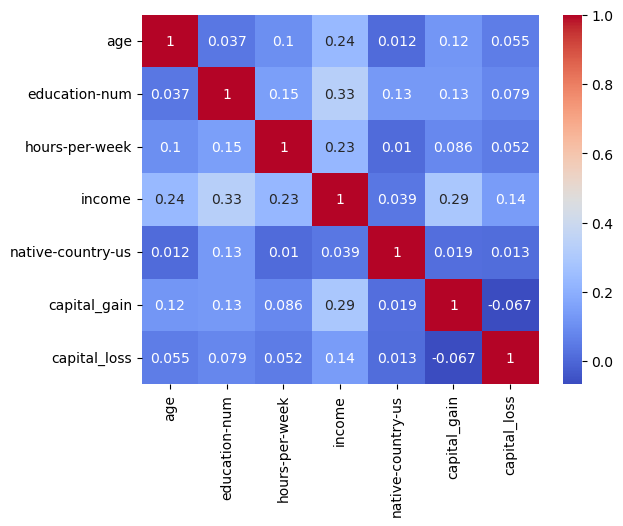

In [24]:
corr = dataset.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

# brak istotnej współliniowości pomiędzy zmiennymi numerycznymi

Macierz korelacji wskazuje na brak istotnej współliniowości pomiędzy zmiennymi numerycznymi. Zależności liniowe są słabe, dlatego wszystkie cechy mogą zostać wykorzystane w dalszym modelowaniu.

## EDA dla przygotowanego zbioru danych 

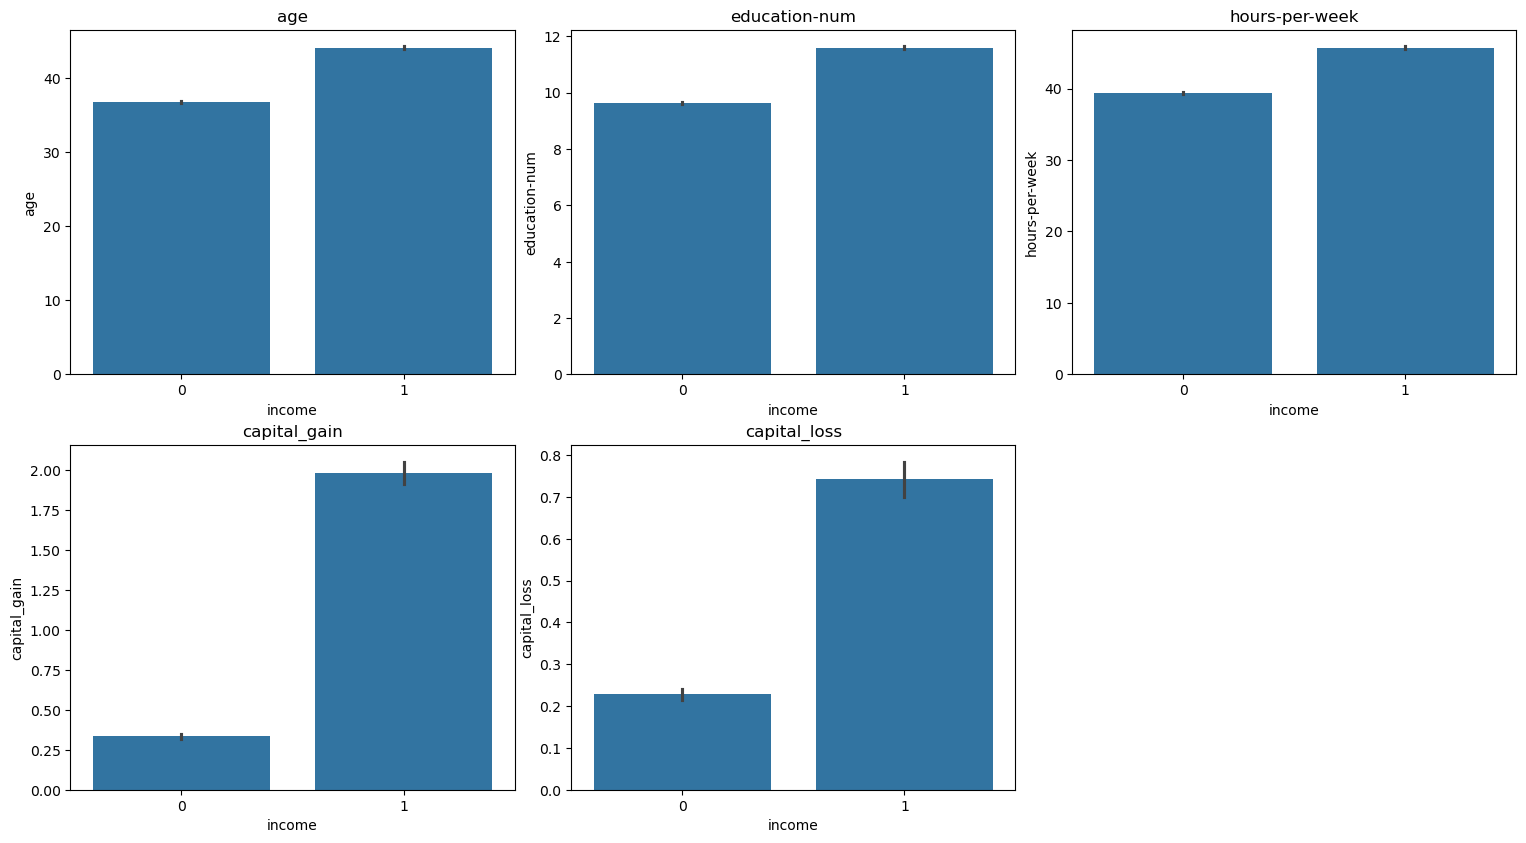

In [25]:
# EDA dla zmiennych numerycznych
f, axes = plt.subplots(2, 3, figsize=[15, 8])
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=3.0)

cols = [c for c in dataset.select_dtypes(include=np.number).columns
        if c not in ["income", "native-country-us"]]

positions = [
    axes[0, 0], axes[0, 1], axes[0, 2],   
    axes[1, 0], axes[1, 1]                
]

for ax, col in zip(positions, cols[:5]):
    sns.barplot(x="income", y=col, data=dataset, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("income")
    ax.set_ylabel(col)

f.delaxes(axes[1, 2])

plt.show()


### Zmienne numeryczne a *income*

Wykresy prezentują średnie wartości zmiennych numerycznych w dwóch klasach zmiennej celu, z zaznaczeniem niepewności estymacji (kreski błędu). Dla wszystkich analizowanych cech (*age*, *education-num*, *hours-per-week*, *capital_gain*, *capital_loss*) obserwuje się wyższe wartości średnie w grupie *income* = 1 niż w *income* = 0, co wskazuje na ich dodatni związek z prawdopodobieństwem uzyskania wyższego dochodu. Najwyraźniejsza separacja klas występuje dla *capital_gain*, natomiast pozostałe zmienne różnicują klasy w sposób umiarkowany, lecz konsekwentny.


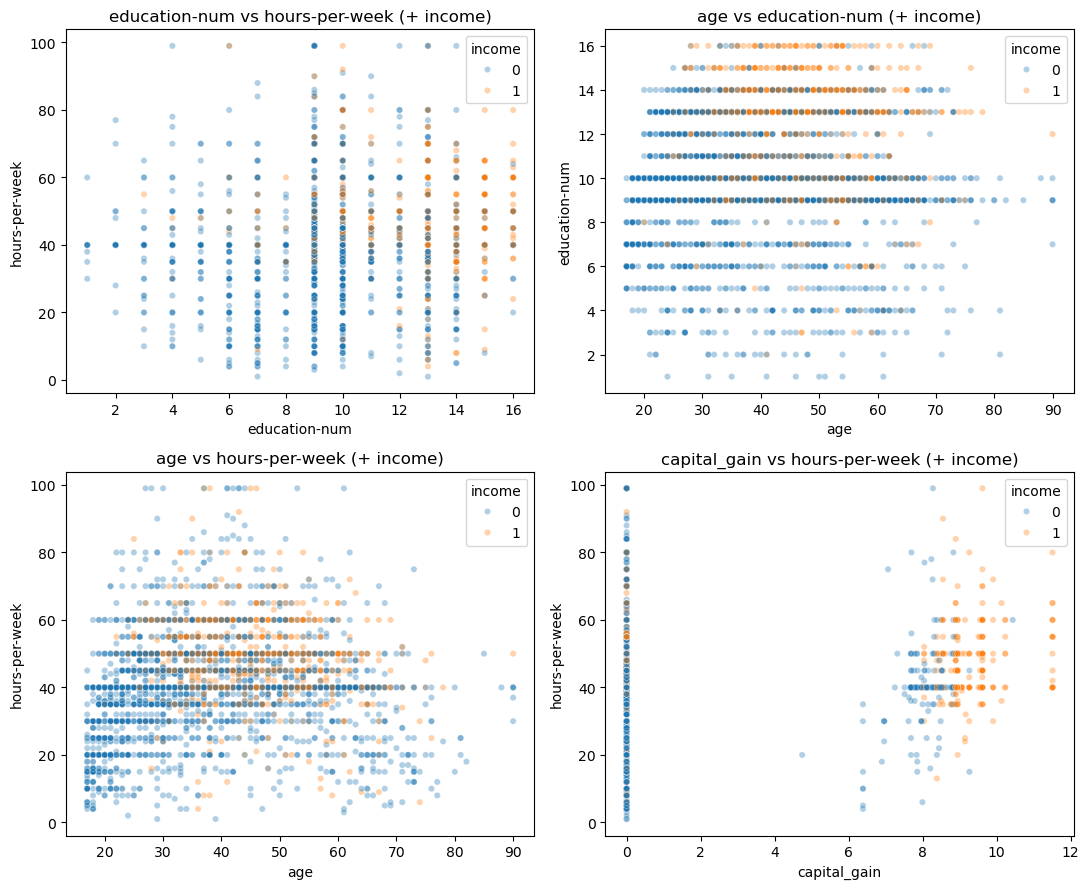

In [26]:

df = dataset.copy()
target_col = "income"

# lista par
pairs = [
    ("education-num", "hours-per-week"),
    ("age", "education-num"),
    ("age", "hours-per-week"),
    ("capital_gain", "hours-per-week")
]

pairs = [(x, y) for x, y in pairs if (x in df.columns and y in df.columns)]

# próbka
sample = df.sample(min(5000, len(df)), random_state=42)

n = len(pairs)
n_cols = 2
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5*n_cols, 4.5*n_rows))
axes = np.array(axes).reshape(-1)

for i, (x, y) in enumerate(pairs):
    ax = axes[i]
    sns.scatterplot(
        data=sample,
        x=x, y=y,
        hue=target_col,
        alpha=0.35,
        s=20,
        ax=ax
    )
    ax.set_title(f"{x} vs {y} (+ income)")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Zależności między wybranymi zmiennymi a *income*

Wykresy rozrzutu przedstawiają relacje pomiędzy parami zmiennych numerycznych, z rozróżnieniem obserwacji według klasy zmiennej celu za pomocą koloru. W przypadku par z udziałem *education-num* widoczna jest koncentracja klasy *income* = 1 przy wyższych poziomach wykształcenia, szczególnie w połączeniu z większą liczbą przepracowanych godzin tygodniowo. Zależności z *age* wskazują na większą częstość klasy *income* = 1 w przedziałach wieku średniego oraz przy wyższych wartościach *education-num*, jednak rozdzielenie klas nie jest jednoznaczne. Najsilniejszy efekt separacji widoczny jest dla *capital_gain* względem *hours-per-week*: obserwacje z niezerowym i wyższym *capital_gain* są wyraźnie częściej klasyfikowane jako *income* = 1, co sugeruje wysoką wartość predykcyjną tej cechy.

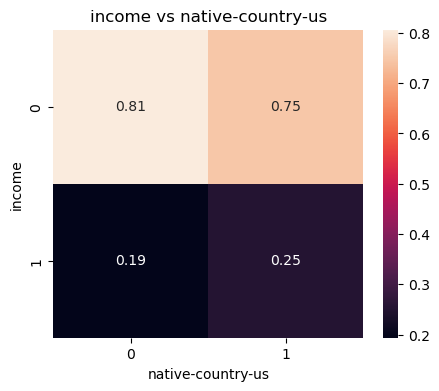

In [27]:
# EDA dla native-country-us (bin)
b = "native-country-us"      
a = "income"                

# counts       
ct_prop = pd.crosstab(dataset[a], dataset[b], normalize="columns") 

plt.figure(figsize=(5,4))
sns.heatmap(ct_prop, annot=True, fmt=".2f")
plt.title(f"{a} vs {b}")
plt.xlabel(b); plt.ylabel(a)
plt.show()

### Heatmapa dla dwóch zmiennych binarnych

Heatmapa przedstawia rozkład częstości (udziałów) klas zmiennej celu *income* w zależności od wartości zmiennej binarnej *native-country-us*. W obu grupach dominuje klasa *income* = 0, jednak dla *native-country-us* = 1 udział obserwacji z *income* = 1 jest wyższy niż dla *native-country-us* = 0. Wynik sugeruje dodatnią, lecz umiarkowaną zależność między pochodzeniem z USA a większym prawdopodobieństwem osiągania wyższego dochodu.

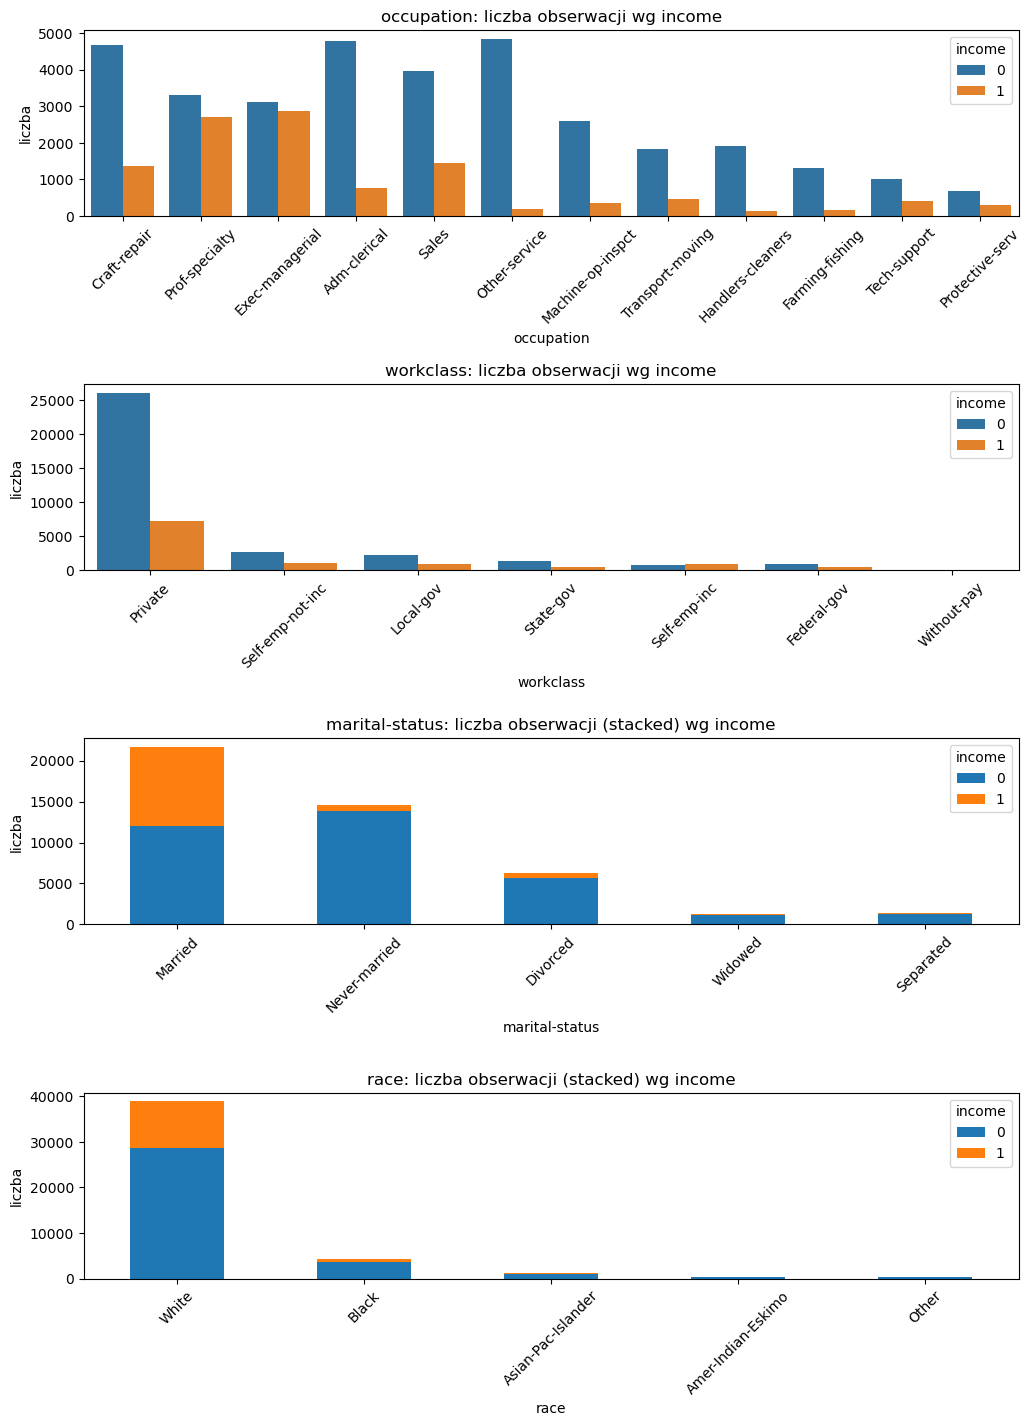

In [28]:
# EDA dla zmiennych jakościowych
fig, axes = plt.subplots(4, 1, figsize=(10, 13))
plt.tight_layout(pad=0.8, h_pad=10)

# 1) occupation
cat_col = "occupation"
order = dataset[cat_col].value_counts().index
sns.countplot(data=dataset, x=cat_col, hue="income", order=order, ax=axes[0])
axes[0].set_title(f"{cat_col}: liczba obserwacji wg income")
axes[0].set_xlabel(cat_col); axes[0].set_ylabel("liczba")
axes[0].tick_params(axis="x", rotation=45)

# 2) workclass 
cat_col = "workclass"
order = dataset[cat_col].value_counts().index
sns.countplot(data=dataset, x=cat_col, hue="income", order=order, ax=axes[1])
axes[1].set_title(f"{cat_col}: liczba obserwacji wg income")
axes[1].set_xlabel(cat_col); axes[1].set_ylabel("liczba")
axes[1].tick_params(axis="x", rotation=45)

# 3) marital-status 
cat_col = "marital-status"
ct = pd.crosstab(dataset[cat_col], dataset["income"]).sort_values(by=1, ascending=False)
ct.plot(kind="bar", stacked=True, ax=axes[2])
axes[2].set_title(f"{cat_col}: liczba obserwacji (stacked) wg income")
axes[2].set_xlabel(cat_col); axes[2].set_ylabel("liczba")
axes[2].tick_params(axis="x", rotation=45)

# 4) race 
cat_col = "race"
ct = pd.crosstab(dataset[cat_col], dataset["income"]).sort_values(by=1, ascending=False)
ct.plot(kind="bar", stacked=True, ax=axes[3])
axes[3].set_title(f"{cat_col}: liczba obserwacji (stacked) wg income")
axes[3].set_xlabel(cat_col); axes[3].set_ylabel("liczba")
axes[3].tick_params(axis="x", rotation=45)

plt.show()


### Zmienne kategorialne a *income*

Wykresy przedstawiają liczebności obserwacji w przekroju wybranych zmiennych kategorialnych z rozbiciem na klasy zmiennej celu. We wszystkich przekrojach widoczna jest przewaga klasy *income* = 0, co potwierdza niezbalansowanie danych.

Dla zmiennej *occupation* relatywnie większy udział obserwacji z *income* = 1 występuje w kategoriach **Exec-managerial** oraz **Prof-specialty**, podczas gdy w zawodach usługowych i pomocniczych (np. **Other-service**, **Handlers-cleaners**, **Farming-fishing**) klasa *income* = 1 pojawia się wyraźnie rzadziej. Wskazuje to, że typ wykonywanej pracy różnicuje prawdopodobieństwo uzyskania wyższego dochodu.

W przypadku *workclass* największa część próby pochodzi z kategorii **Private**, w której dominuje *income* = 0, jednak widoczna jest również istotna liczba obserwacji z *income* = 1. Kategorie samozatrudnienia mają mniejszą liczebność, ale relatywnie częściej zawierają obserwacje z *income* = 1, co sugeruje potencjalnie odmienny profil dochodowy w tej grupie.

Dla *marital-status* najwyższa koncentracja klasy *income* = 1 występuje w kategorii **Married**, natomiast w grupie **Never-married** wyraźnie dominuje *income* = 0. Pozostałe kategorie (np. **Divorced**, **Widowed**, **Separated**) są mniej liczne i charakteryzują się niższym udziałem *income* = 1.

Wykres dla *race* pokazuje silną nierównowagę liczebności kategorii (dominacja **White**), co oznacza, że różnice pomiędzy pozostałymi grupami należy interpretować ostrożnie ze względu na mniejsze próby. Mimo to, rozkłady wskazują, że udział klasy *income* = 1 różni się pomiędzy kategoriami.


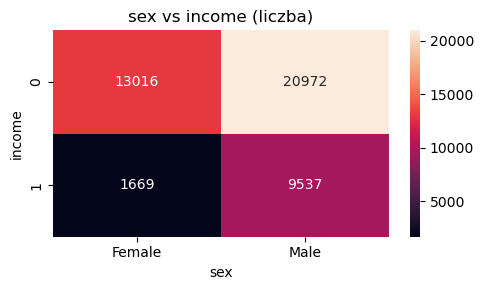

In [29]:
cat_col = "sex"
ct = pd.crosstab(dataset[a], dataset[cat_col])

plt.figure(figsize=(5,3))
sns.heatmap(ct, annot=True, fmt="d")
plt.title(f"{cat_col} vs income (liczba)")
plt.xlabel(cat_col)
plt.ylabel(a)
plt.tight_layout()
plt.show()


### Heatmapa *sex* a *income*

Heatmapa przedstawia liczebności obserwacji w przekroju płci oraz klasy zmiennej celu. W obu grupach dominuje *income* = 0, jednak wśród mężczyzn liczba przypadków z *income* = 1 jest wyraźnie wyższa niż wśród kobiet (9537 vs 1669). Oznacza to, że w analizowanym zbiorze obserwuje się silną zależność pomiędzy płcią a częstszym występowaniem klasy *income* = 1, przy jednoczesnym utrzymaniu niezbalansowania klas w każdej z grup.


In [30]:
# podział danych na zbiór treningowy i testowy
X = dataset.drop('income', axis=1)
y = dataset['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Przekształcanie zmiennych ciągłych
num_transformer = StandardScaler()

# Przekształcanie zmiennych jakościowych
cat_transformer = OneHotEncoder()

In [32]:
transform = ColumnTransformer(
    transformers=[
        ('num', num_transformer, ["age", "education-num", "capital_gain", "capital_loss", "hours-per-week"]),
        ('cat', cat_transformer, ["workclass", "marital-status", 'occupation', 'race',
                                  'sex',"relationship"]),
        ('bin', "passthrough", ['native-country-us'])],
        remainder = "drop"
    )  

### Model regresji logistycznej, tuning hipermarametrów

Dane podzielono na zbiór treningowy i testowy w proporcji 80/20. Zastosowano standaryzację zmiennych ciągłych oraz kodowanie One-Hot dla zmiennych kategorialnych. Regresja logistyczna została osadzona w pipeline wraz z etapem preprocessingu. W celu optymalizacji modelu przeprowadzono strojenie hiperparametrów metodą GridSearchCV z 5-krotną walidacją krzyżową. Jako metrykę oceny wybrano F1-score, który jest odpowiedni w przypadku problemów z niezbalansowanymi klasami.

Najlepsze wyniki uzyskano dla parametru regularizacji C ≈ 1.23, przy zastosowaniu regularyzacji L2 oraz solvera liblinear.

In [33]:
pipe1 = Pipeline(steps=[
    ("preprocess", transform),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Definicja siatki hiperparametrów dla regresji logistycznej
param_grid1 = {
    "model__C": np.linspace(0.01, 10, 50),
    "model__penalty": ["l2"],
    "model__solver": ["liblinear"]
}

# GridSearchCV z 5-krotną walidacją krzyżową. Jako metrykę optymalizacji wybrano F1-score, który jest odpowiedni w przypadku niezbalansowanych klas
tuning_res_lr= GridSearchCV(
    pipe1,
    param_grid1,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

tuning_res_lr.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education-num',
                                                                          'capital_gain',
                                                                          'capital_loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['workclass',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'race',
                                                                          'sex',
                                                                          'relationship']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['native-country-us'])])),
                                       ('model',
                                        LogisticRegr...
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ]),
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear']},
             scoring='f1', verbose=2)

In [34]:
# zestaw hiperparametrów, który maksymalizował średni wynik F1-score w 5-krotnej walidacji krzyżowej.
tuning_res_lr.best_params_

{'model__C': np.float64(1.233265306122449),
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [35]:
tuning_res_lr.best_score_

np.float64(0.6748553529433788)

Na podstawie wyników strojenia hiperparametrów wybrano najlepszy model regresji logistycznej, który następnie wykorzystano do predykcji na zbiorach treningowym i testowym.

Ocenę jakości modelu przeprowadzono przy użyciu metryk F1-score oraz Accuracy. Uzyskane wyniki są zbliżone dla obu zbiorów (F1 ≈ 0.68, Accuracy ≈ 0.80), co wskazuje na brak przeuczenia modelu i dobrą zdolność generalizacji.

Dodatkowo obliczono macierze pomyłek dla obu zbiorów. Wyniki pokazują, że model poprawnie klasyfikuje większość obserwacji. W przypadku klasy osób o wyższym dochodzie (>50K) model charakteryzuje się wysoką czułością (recall ≈ 0.85), jednak niższą precyzją (precision ≈ 0.57), co oznacza, że część obserwacji została błędnie zaklasyfikowana do tej grupy. Jest to typowe w przypadku niezbalansowanych zbiorów danych.

In [36]:
#wybór najlepszego modelu
best_model_lr = tuning_res_lr.best_estimator_

#predykcje dla zbioru train/test
y_pred_test = best_model_lr.predict(X_test)
y_pred_train = best_model_lr.predict(X_train)

#obliczenie metryk jakości
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
acc = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

print("F1-score (test):", f1_test)
print("F1-score (train):", f1_train)
print("Accuracy (test):", acc)
print("Accuracy (train):", acc_train)

# Model nie wykazuje przeuczenia (overfittingu) - wyniki metryk dla test i train są bradzo zbliżone

F1-score (test): 0.6822479928635147
F1-score (train): 0.6756378414992098
Accuracy (test): 0.802964929748866
Accuracy (train): 0.8013276172037063


In [37]:
cm_train = confusion_matrix(y_train, y_pred_train)
print("Macierz pomyłek dla zbioru uczącego:")
print(cm_train)

cm_test = confusion_matrix(y_test, y_pred_test)
print("Macierz pomyłek dla zbioru testowego:")
print(cm_test)

Macierz pomyłek dla zbioru uczącego:
[[21491  5719]
 [ 1464  7481]]
Macierz pomyłek dla zbioru testowego:
[[5346 1432]
 [ 349 1912]]


In [38]:
print(classification_report(y_test, y_pred_test))
# Model charakteryzuje się wysoką czułością (recall=0.85) dla klasy 1, co oznacza, że większość osób z dochodem >50K została poprawnie wykryta.
# Jednocześnie precyzja dla tej klasy jest niższa.

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      6778
           1       0.57      0.85      0.68      2261

    accuracy                           0.80      9039
   macro avg       0.76      0.82      0.77      9039
weighted avg       0.85      0.80      0.81      9039



AUC_test: 0.8986539561546846 AUC_train: 0.897503934473175


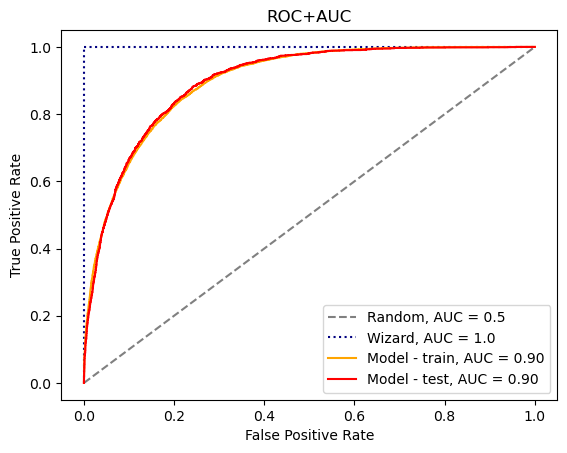

In [39]:
y_prob_train = best_model_lr.predict_proba(X_train)[:,1]
y_prob_test = best_model_lr.predict_proba(X_test)[:, 1]

fprv, tprv, _ = roc_curve(y_test, y_prob_test)
fprt, tprt, _ = roc_curve(y_train, y_prob_train)

auc_test = roc_auc_score(y_test, y_prob_test)
auc_train = roc_auc_score(y_train, y_prob_train)
print("AUC_test:", auc_test, "AUC_train:", auc_train)

plt.figure()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC+AUC")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random, AUC = 0.5")
plt.plot([0, 0], [0, 1], color="navy", linestyle=":", label="Wizard, AUC = 1.0")
plt.plot([0, 1], [1, 1], color="navy", linestyle=":")

plt.plot(fprt, tprt, color="orange", label="Model - train, AUC = %0.2f" % auc_train)
plt.plot(fprv, tprv, color="red", label="Model - test, AUC = %0.2f" % auc_test)
plt.legend(loc="lower right");

Wartości AUC na poziomie około 0.90 dla zbioru treningowego i testowego wskazują na bardzo dobrą zdolność modelu do rozróżniania klas oraz brak przeuczenia. Krzywa ROC znajduje się wyraźnie powyżej linii losowej klasyfikacji.

In [40]:
#tworzenie tabeli z ilorazami szans

feature_names = best_model_lr.named_steps["preprocess"].get_feature_names_out()
odds_ratio = np.exp(best_model_lr.named_steps["model"].coef_)

df_or = pd.DataFrame({
    "feature": feature_names,
    "odds_ratio": odds_ratio[0]}).sort_values("odds_ratio", ascending=False)
df_or

,feature,odds_ratio
41,cat__relationship_Wife,5.520314
1,num__education-num,2.073065
19,cat__occupation_Exec-managerial,2.068131
13,cat__marital-status_Married,1.956754
24,cat__occupation_Prof-specialty,1.747886
25,cat__occupation_Protective-serv,1.722899
2,num__capital_gain,1.716354
27,cat__occupation_Tech-support,1.664641
5,cat__workclass_Federal-gov,1.633489
36,cat__relationship_Husband,1.593187


Najsilniejszy pozytywny wpływ na prawdopodobieństwo osiągnięcia dochodu powyżej 50K ma zmienna "relationship = Wife" (OR ≈ 5.5), co oznacza ponad pięciokrotnie większe szanse wysokiego dochodu w porównaniu do pozostałych kategorii tej zmiennej. Istotne znaczenie ma również poziom wykształcenia – wzrost "education-num" o jedną jednostkę ponad dwukrotnie zwiększa szanse wysokich zarobków (OR ≈ 2.07). Im wyższy jest poziom wykształcenia, tym większe jest prawdopodobieństwo wyższego dochodu.

Z kolei zmienne o ilorazach szans mniejszych od 1 obniżają prawdopodobieństwo wysokiego dochodu. Najsilniejszy negatywny wpływ obserwowany jest dla kategorii "relationship = Own-child" (OR ≈ 0.30). Niższe szanse wysokich zarobków dotyczą także m.in. osób pracujących w zawodach Farming-fishing i Other-service, osób nigdy niebędących w związku małżeńskim oraz kobiet.

# Random Forest 

In [41]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd

In [42]:
pipe_rf_reg = Pipeline(steps=[
    ("preprocess", transform),  # Przetwarzanie danych zgodnie z wcześniej zdefiniowanym

    # konwersja do formatu CSC
    ("to_csc", FunctionTransformer(
        lambda x: x.tocsc() if hasattr(x, "tocsc") else x,
        accept_sparse=True
    )),

    # Model Random Forest (las losowy)
    ("model", RandomForestClassifier(
        random_state=42,     # powtarzalność wyników
        n_jobs=1,            # unikamy zagnieżdżonej równoległości
        bootstrap=True,      # potrzebne do max_samples oraz oob_score
        oob_score=True       # dodatkowa kontrola generalizacji (poza CV)
    ))
])

In [43]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
param_dist_rf = {
    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [None, 8, 12, 16],
    "model__min_samples_leaf": [2, 5, 10, 20],
    "model__min_samples_split": [2, 10, 30, 100],
    "model__max_features": ["sqrt", 0.3, 0.5],
    "model__max_leaf_nodes": [None, 50, 100, 200],
    "model__max_samples": [0.6, 0.8, 1.0],
    "model__ccp_alpha": [0.0, 1e-4, 5e-4, 1e-3, 5e-3],
    "model__class_weight": ["balanced", "balanced_subsample"],
}

In [45]:
tuning_res_rf = RandomizedSearchCV(
    estimator=pipe_rf_reg,      # preprocess -> to_csc -> random forest
    param_distributions=param_dist_rf,
    n_iter=35,                  # liczba losowo sprawdzanych konfiguracji
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,            # powtarzalność losowania konfiguracji
    return_train_score=True,
    refit=True
)

In [46]:
tuning_res_rf.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'education-num',
                                                                                'capital_gain',
                                                                                'capital_loss',
                                                                                'hours-per-week']),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['workclass',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'race',
                                                                                'sex',
                                                                                'relationship']),
                                                                              ('bin',...
                                                                'balanced_subsample'],
                                        'model__max_depth': [None, 8, 12, 16],
                                        'model__max_features': ['sqrt', 0.3,
                                                                0.5],
                                        'model__max_leaf_nodes': [None, 50, 100,
                                                                  200],
                                        'model__max_samples': [0.6, 0.8, 1.0],
                                        'model__min_samples_leaf': [2, 5, 10,
                                                                    20],
                                        'model__min_samples_split': [2, 10, 30,
                                                                     100],
                                        'model__n_estimators': [300, 600, 900]},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=2)

In [47]:
# Wyświetlenie najlepszej znalezionej konfiguracji
print("best params:", tuning_res_rf.best_params_)
# Najlepszy średni wynik F1
print("best cv f1:", tuning_res_rf.best_score_)

best params: {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10, 'model__max_samples': 0.8, 'model__max_leaf_nodes': 200, 'model__max_features': 0.3, 'model__max_depth': 16, 'model__class_weight': 'balanced', 'model__ccp_alpha': 0.0}
best cv f1: 0.6981188368305591


In [48]:
# Pobranie gotowego pipeline’u z najlepszymi hiperparametrami 
best_rf = tuning_res_rf.best_estimator_

In [49]:
# Predykcje klas (0/1) na zbiorze treningowym i testowym
y_pred_train = best_rf.predict(X_train)
y_pred_test  = best_rf.predict(X_test)

In [50]:
# proba dla ROC AUC
y_proba_train = best_rf.predict_proba(X_train)[:, 1]
y_proba_test  = best_rf.predict_proba(X_test)[:, 1]

In [51]:
# ROC AUC na train i test
roc_auc_train = roc_auc_score(y_train, y_proba_train)
roc_auc_test  = roc_auc_score(y_test,  y_proba_test)

In [52]:
# Wyniki na train: kontrola, czy model nie dopasował się zbyt mocno do danych treningowych
print("\n=== Wyniki: TRAIN ===")
print("f1:", f1_score(y_train, y_pred_train))
print("accuracy:", accuracy_score(y_train, y_pred_train))
print("roc auc (train):", roc_auc_train)


=== Wyniki: TRAIN ===
f1: 0.7127993093734382
accuracy: 0.8251694094869313
roc auc (train): 0.9270968733957302


In [53]:
# Wyniki na test: kluczowa ocena jakości generalizacji na danych niewidzianych podczas treningu
print("\n=== Wyniki: TEST ===")
print("f1:", f1_score(y_test, y_pred_test))
print("accuracy:", accuracy_score(y_test, y_pred_test))
print("roc auc (test): ", roc_auc_test)


=== Wyniki: TEST ===
f1: 0.7041144901610018
accuracy: 0.8170151565438655
roc auc (test):  0.9199277092458639


Na zbiorze testowym model Random Forest uzyskał **f1 = 0.704** oraz **accuracy = 0.817**. Wyniki na zbiorze treningowym są zbliżone (**f1 = 0.713**, **accuracy = 0.825**), co wskazuje na brak wyraźnych oznak przeuczenia i dobrą generalizację. Wartość **roc auc = 0.920** potwierdza, że model dobrze rozróżnia klasy niezależnie od przyjętego progu decyzyjnego.


In [54]:
print("\n=== Confusion matrix (TEST) ===")
print(confusion_matrix(y_test, y_pred_test))


=== Confusion matrix (TEST) ===
[[5417 1361]
 [ 293 1968]]


* **TN = 5417** – poprawnie sklasyfikowane obserwacje klasy 0
* **FP = 1361** – błędnie przypisane do klasy 1 (fałszywe alarmy)
* **FN = 293** – obserwacje klasy 1 pominięte przez model
* **TP = 1968** – poprawnie wykryte obserwacje klasy 1

Wynik pokazuje, że model stosunkowo rzadko pomija klasę 1 (FN jest niewielkie), natomiast część obserwacji klasy 0 jest mylnie oznaczana jako klasa 1 (FP jest zauważalne).


In [55]:
print("\n=== Classification report (TEST) ===")
print(classification_report(y_test, y_pred_test))


=== Classification report (TEST) ===
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      6778
           1       0.59      0.87      0.70      2261

    accuracy                           0.82      9039
   macro avg       0.77      0.83      0.79      9039
weighted avg       0.86      0.82      0.83      9039



Dla **klasy 1** model ma **recall = 0.87**, czyli poprawnie wykrywa większość obserwacji tej klasy, natomiast **precision = 0.59**, co oznacza, że część predykcji klasy 1 to przypadki błędne (zgodne z wysoką liczbą FP w macierzy pomyłek). Dla **klasy 0** precision jest bardzo wysokie (**0.95**), ale recall niższy (**0.80**), ponieważ część obserwacji klasy 0 zostaje zaklasyfikowana jako 1. Całościowo model osiąga **accuracy = 0.82** oraz **f1-score = 0.70** dla klasy 1, co jest spójne z przyjętą optymalizacją pod metrykę F1.


In [56]:
# 6) Podgląd: które konfiguracje miały duży gap train-test w CV (pomaga ocenić przeuczenie)
cv_res = pd.DataFrame(tuning_res_rf.cv_results_)
cv_res["gap_train_test"] = cv_res["mean_train_score"] - cv_res["mean_test_score"]
cv_res_sorted = cv_res.sort_values(["rank_test_score", "gap_train_test"], ascending=[True, True])

In [57]:
print("\nTop 10 konfiguracji (najlepszy CV F1 + mały gap):")
display(cv_res_sorted[[
    "rank_test_score", "mean_test_score", "mean_train_score", "gap_train_test",
    "param_model__max_depth", "param_model__min_samples_leaf",
    "param_model__min_samples_split", "param_model__max_samples",
    "param_model__ccp_alpha", "param_model__max_leaf_nodes",
    "param_model__max_features", "param_model__n_estimators"
]].head(10))


Top 10 konfiguracji (najlepszy CV F1 + mały gap):


,rank_test_score,mean_test_score,mean_train_score,gap_train_test,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_model__max_samples,param_model__ccp_alpha,param_model__max_leaf_nodes,param_model__max_features,param_model__n_estimators
3,1,0.698119,0.715077,0.016958,16,10,2,0.8,0.0000,200,0.3,600
19,2,0.694948,0.706877,0.011929,12,10,2,0.6,0.0001,100,0.5,900
29,3,0.694322,0.710838,0.016516,12,5,30,0.6,0.0000,200,0.3,300
11,4,0.692195,0.699931,0.007735,None,2,2,0.8,0.0000,50,0.3,600
16,5,0.692109,0.706785,0.014676,16,10,30,1.0,0.0000,None,sqrt,600
24,6,0.690072,0.698563,0.008491,None,5,2,0.8,0.0005,None,0.5,600
1,7,0.689792,0.696938,0.007146,None,20,30,1.0,0.0000,50,0.3,900
20,8,0.689587,0.698064,0.008477,12,20,100,1.0,0.0001,200,0.3,900
8,9,0.689287,0.696688,0.007401,16,2,2,0.8,0.0005,50,0.5,900
18,10,0.688846,0.694935,0.006089,None,20,2,0.6,0.0005,200,0.3,600


W top 10 najlepszych konfiguracji wartości **gap_train_test** są niewielkie (około **0.006–0.017**), co wskazuje, że model nie osiąga dobrych wyników wyłącznie dzięki “dopasowaniu” do danych treningowych, tylko zachowuje podobną jakość na walidacji. Najlepsza konfiguracja w tej grupie uzyskała średnio **F1 ≈ 0.698** w walidacji przy **F1 ≈ 0.715** na treningu (gap ≈ 0.017), co sugeruje dobrą równowagę między jakością a generalizacją.

In [58]:
# 7) Dodatkowy sygnał generalizacji: OOB score (jeśli bootstrap=True)
#    UWAGA: oob_score_ jest dostępne na etapie modelu, nie całego pipeline'a
rf_model = best_rf.named_steps["model"]
print("\nOOB score (pomocniczo):", getattr(rf_model, "oob_score_", None))


OOB score (pomocniczo): 0.8159037477527313


**oob_score ≈ 0.816** jest zbliżony do accuracy na zbiorze testowym, co sugeruje, że model zachowuje podobną jakość poza danymi treningowymi i nie wykazuje wyraźnych oznak przeuczenia.

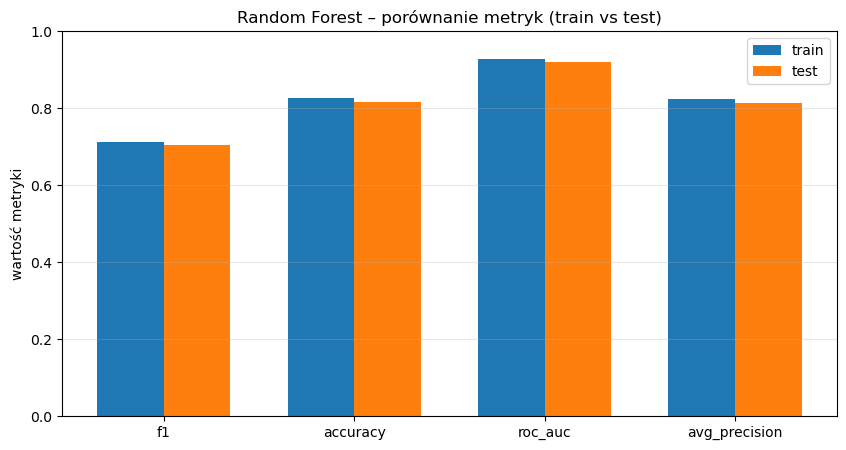

In [59]:
# =========================
# Wykres: metryki TRAIN vs TEST
# =========================

metrics_rf = {
    "f1": (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)),
    "accuracy": (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)),
    "roc_auc": (roc_auc_train, roc_auc_test),
    "avg_precision": (
        average_precision_score(y_train, y_proba_train),
        average_precision_score(y_test, y_proba_test)
    )
}

labels = list(metrics_rf.keys())
train_vals = [metrics_rf[k][0] for k in labels]
test_vals  = [metrics_rf[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train_vals, width, label="train")
plt.bar(x + width/2, test_vals, width, label="test")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("wartość metryki")
plt.title("Random Forest – porównanie metryk (train vs test)")
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.show()


Wartości metryk dla train i test są bardzo podobne, więc model zachowuje się stabilnie. Najlepiej wypadają miary oparte na prawdopodobieństwach (roc auc i avg precision), co oznacza, że model dobrze rozróżnia obserwacje. Relatywnie niższy f1 sugeruje, że największy potencjał poprawy leży w doborze progu decyzyjnego, a nie w samym dopasowaniu modelu.


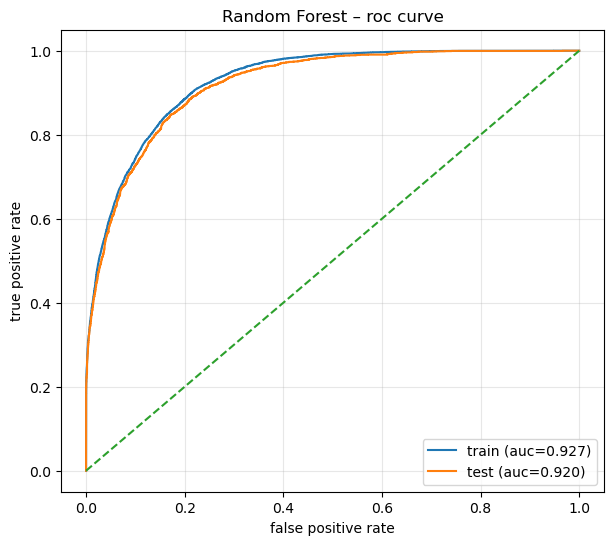

In [60]:
# =========================
# ROC curve (train vs test)
# =========================

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_proba_train)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_proba_test)

plt.figure(figsize=(7, 6))
plt.plot(fpr_tr, tpr_tr, label=f"train (auc={roc_auc_train:.3f})")
plt.plot(fpr_te, tpr_te, label=f"test (auc={roc_auc_test:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Random Forest – roc curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Krzywe ROC dla train i test prawie się pokrywają i leżą wyraźnie powyżej linii losowej, co potwierdza dobrą zdolność modelu do rozróżniania klas. AUC na teście (0.920) jest bardzo blisko AUC na treningu (0.927), więc nie widać istotnej utraty jakości na danych niewidzianych.

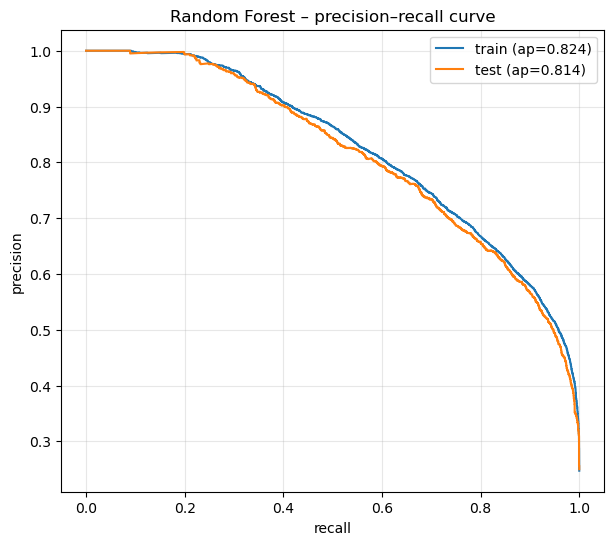

In [61]:
# =========================
# Precision–Recall curve (train vs test)
# =========================

prec_tr, rec_tr, _ = precision_recall_curve(y_train, y_proba_train)
prec_te, rec_te, _ = precision_recall_curve(y_test,  y_proba_test)

ap_tr = average_precision_score(y_train, y_proba_train)
ap_te = average_precision_score(y_test,  y_proba_test)

plt.figure(figsize=(7, 6))
plt.plot(rec_tr, prec_tr, label=f"train (ap={ap_tr:.3f})")
plt.plot(rec_te, prec_te, label=f"test (ap={ap_te:.3f})")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Random Forest – precision–recall curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Krzywa precision–recall pokazuje typowy kompromis: gdy zwiększamy recall, precision stopniowo spada. Linie dla train i test są bardzo blisko siebie, a **average precision** jest podobne (0.824 vs 0.814), co oznacza stabilne działanie modelu także dla klasy pozytywnej. W praktyce wykres sugeruje, że dalsze “dostrajanie” wyniku (np. pod wyższy recall albo wyższą precyzję) najlepiej robić przez dobór progu decyzyjnego.


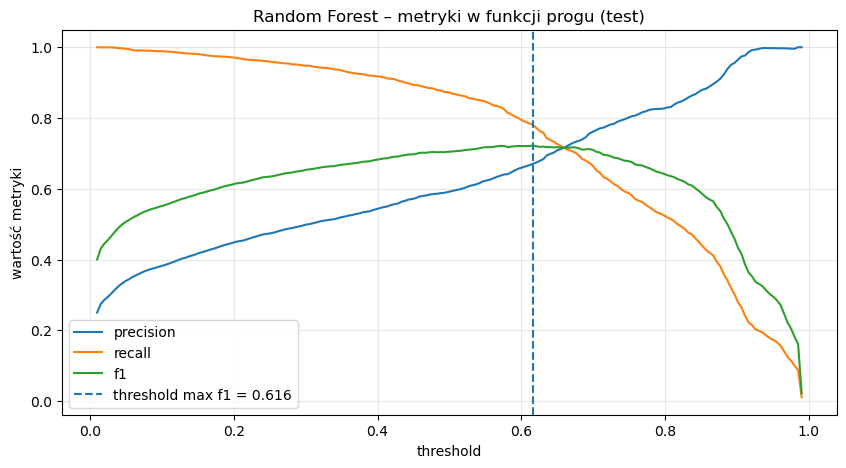

threshold (max f1): 0.6157286432160805 f1: 0.7216663263222379


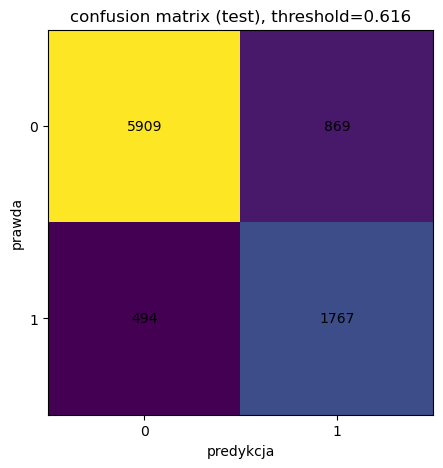

In [62]:
# =========================
# Metryki vs threshold (test) + wybór progu
# =========================

thresholds = np.linspace(0.01, 0.99, 200)
prec_list, rec_list, f1_list = [], [], []

for t in thresholds:
    yhat = (y_proba_test >= t).astype(int)

    tp = np.sum((yhat == 1) & (y_test == 1))
    fp = np.sum((yhat == 1) & (y_test == 0))
    fn = np.sum((yhat == 0) & (y_test == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    prec_list.append(precision)
    rec_list.append(recall)
    f1_list.append(f1)

prec_list = np.array(prec_list)
rec_list  = np.array(rec_list)
f1_list   = np.array(f1_list)

best_idx = np.argmax(f1_list)
best_t = thresholds[best_idx]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, prec_list, label="precision")
plt.plot(thresholds, rec_list, label="recall")
plt.plot(thresholds, f1_list, label="f1")
plt.axvline(best_t, linestyle="--", label=f"threshold max f1 = {best_t:.3f}")
plt.xlabel("threshold")
plt.ylabel("wartość metryki")
plt.title("Random Forest – metryki w funkcji progu (test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("threshold (max f1):", best_t, "f1:", f1_list[best_idx])

# Confusion matrix dla progu best_t
yhat_best_t = (y_proba_test >= best_t).astype(int)
cm_best_t = confusion_matrix(y_test, yhat_best_t)

plt.figure(figsize=(5.5, 5))
plt.imshow(cm_best_t)
plt.title(f"confusion matrix (test), threshold={best_t:.3f}")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("predykcja")
plt.ylabel("prawda")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_best_t[i, j], ha="center", va="center")

plt.show()


Wykres pokazuje typową zależność: wraz ze wzrostem progu **precision rośnie**, a **recall spada**. Maksimum **f1** na zbiorze testowym wypada dla progu ok. **0.616** (f1 ≈ **0.722**), czyli wyraźnie powyżej domyślnego 0.5.

Dla tego progu macierz pomyłek to **TN=5909, FP=869, FN=494, TP=1767** – w porównaniu do progu 0.5 model robi **mniej fałszywych alarmów (FP spada)**, ale częściej **pomija klasę 1 (FN rośnie)**. 


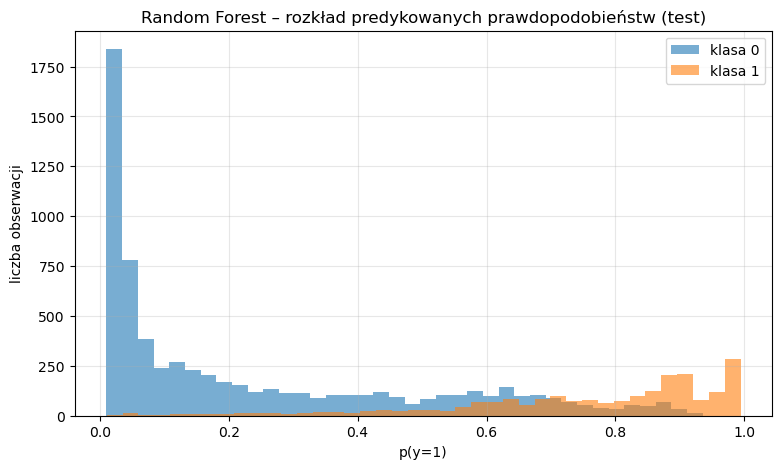

In [63]:
# =========================
# Rozkład prawdopodobieństw (test) dla klas 0 i 1
# =========================

plt.figure(figsize=(9, 5))
plt.hist(y_proba_test[y_test == 0], bins=40, alpha=0.6, label="klasa 0")
plt.hist(y_proba_test[y_test == 1], bins=40, alpha=0.6, label="klasa 1")
plt.xlabel("p(y=1)")
plt.ylabel("liczba obserwacji")
plt.title("Random Forest – rozkład predykowanych prawdopodobieństw (test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Histogram pokazuje, że model w większości przypadków przypisuje **klasie 0** niskie prawdopodobieństwa (skupienie blisko 0), a **klasie 1** wyższe (duża część rozkładu przesunięta w stronę 0.7–1.0). W środkowym zakresie (około 0.4–0.7) widać nakładanie się obu rozkładów – to są obserwacje najbardziej niepewne, na których pojawiają się pomyłki. 

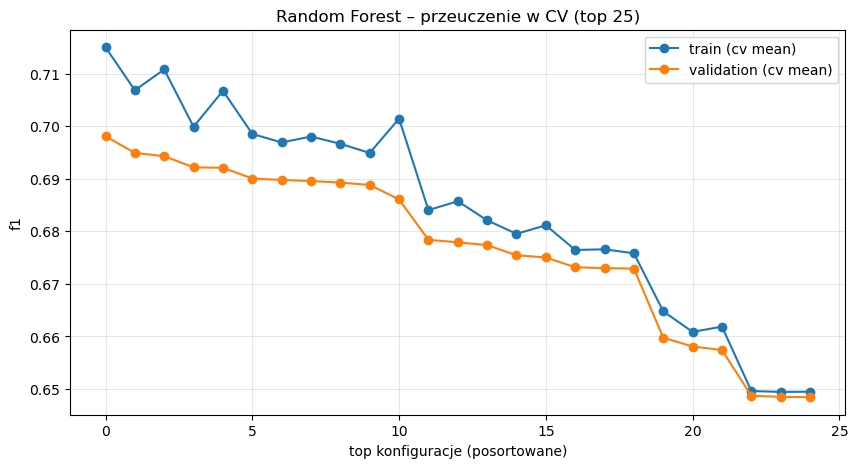

średni gap (top): 0.006966740326235916


In [64]:
# =========================
# CV: train vs validation dla top konfiguracji
# =========================

topN = 25
tmp = cv_res_sorted.head(topN).copy()

plt.figure(figsize=(10, 5))
plt.plot(tmp["mean_train_score"].values, marker="o", label="train (cv mean)")
plt.plot(tmp["mean_test_score"].values, marker="o", label="validation (cv mean)")
plt.xlabel("top konfiguracje (posortowane)")
plt.ylabel("f1")
plt.title(f"Random Forest – przeuczenie w CV (top {topN})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("średni gap (top):", (tmp["mean_train_score"] - tmp["mean_test_score"]).mean())


Wykres pokazuje, że dla najlepszych 25 konfiguracji wyniki na treningu i walidacji są do siebie bardzo zbliżone. Różnica między krzywymi jest niewielka (średni gap ok. **0.007**), więc nie widać silnego przeuczenia w trakcie strojenia. Dodatkowo wraz ze spadkiem jakości konfiguracji obie krzywe maleją podobnie, co sugeruje, że ranking modeli wynika głównie z realnej jakości na walidacji, a nie z “przepasowania” treningu.


# XGBoost

In [65]:
# XGBoost pipeline (z preprocess = transform)

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=1,
    tree_method="hist",
    scale_pos_weight=pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocess", transform),
    ("model", xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [66]:
# RandomizedSearch

dist = {
    "model__n_estimators": stats.randint(200, 800),
    "model__max_depth": stats.randint(2, 8),
    "model__learning_rate": stats.uniform(0.01, 0.25),
    "model__subsample": stats.uniform(0.6, 0.4),   
    "model__colsample_bytree": stats.uniform(0.6, 0.4),
    "model__min_child_weight": stats.randint(1, 10)
}

tuning_res_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=dist,
    scoring="f1",   
    n_iter=25,
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

tuning_res_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'education-num',
                                                                                'capital_gain',
                                                                                'capital_loss',
                                                                                'hours-per-week']),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['workclass',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'race',
                                                                                'sex',
                                                                                'relationship']),
                                                                              ('bin',...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000220BFD12850>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000220BF855940>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000220BFD116D0>},
                   random_state=42, scoring='f1', verbose=2)

In [67]:
# best params + best estimator
print(tuning_res_xgb.best_params_)
Best_XGB = tuning_res_xgb.best_estimator_


{'model__colsample_bytree': np.float64(0.6739417822102108), 'model__learning_rate': np.float64(0.25239615694113965), 'model__max_depth': 3, 'model__min_child_weight': 2, 'model__n_estimators': 401, 'model__subsample': np.float64(0.9579309401710595)}


### Najlepsze parametry modelu

W wyniku procedury strojenia hiperparametrów wybrano konfigurację, w której model wykorzystuje **401 drzew**, przy umiarkowanej złożoności pojedynczego drzewa (*max_depth* = 3) oraz minimalnym wymaganiu liczebności w liściu kontrolowanym przez *min_child_weight* = 2. Zastosowano relatywnie wysoką wartość *learning_rate* ≈ 0.25, co w połączeniu z większą liczbą estymatorów wskazuje na dążenie do stabilnego uczenia przy zachowaniu dobrej jakości predykcji. Dodatkowo mechanizmy losowania cech i obserwacji (*colsample_bytree* ≈ 0.67, *subsample* ≈ 0.96) ograniczają ryzyko przeuczenia i poprawiają uogólnienie modelu.

In [68]:
y_pred_train = Best_XGB.predict(X_train)

In [69]:
#predykcje dla zbioru train/test
y_pred_test = Best_XGB.predict(X_test)
y_pred_train = Best_XGB.predict(X_train)

#obliczenie metryk jakości
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
acc = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

print("F1-score (test):", f1_test)
print("F1-score (train):", f1_train)
print("Accuracy (test):", acc)
print("Accuracy (train):", acc_train)

# Model nie wykazuje przeuczenia (overfittingu) - wyniki metryk dla test i train są bradzo zbliżone

F1-score (test): 0.7253676470588235
F1-score (train): 0.7393219867365395
Accuracy (test): 0.8347162296714238
Accuracy (train): 0.8445304937076477


In [71]:
cm_train = confusion_matrix(y_train, y_pred_train)
print("Macierz pomyłek dla zbioru uczącego:")
print(cm_train)

cm_test = confusion_matrix(y_test, y_pred_test)
print("Macierz pomyłek dla zbioru testowego:")
print(cm_test)

Macierz pomyłek dla zbioru uczącego:
[[22563  4647]
 [  974  7971]]
Macierz pomyłek dla zbioru testowego:
[[5572 1206]
 [ 288 1973]]


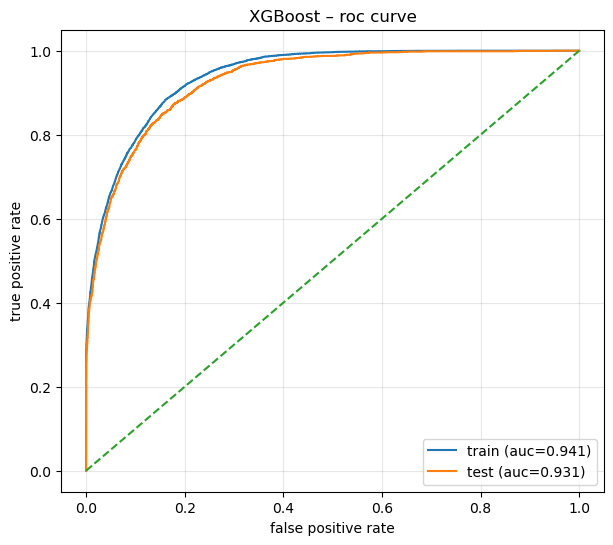

In [72]:
# =========================
# ROC curve (train vs test)
# =========================
y_prob_train = Best_XGB.predict_proba(X_train)[:,1]
y_prob_test = Best_XGB.predict_proba(X_test)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_prob_train)
roc_auc_test  = roc_auc_score(y_test,  y_prob_test)

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_prob_train)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_prob_test)

plt.figure(figsize=(7, 6))
plt.plot(fpr_tr, tpr_tr, label=f"train (auc={roc_auc_train:.3f})")
plt.plot(fpr_te, tpr_te, label=f"test (auc={roc_auc_test:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("XGBoost – roc curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [73]:
# ocena
y_pred = Best_XGB.predict(X_test)
y_proba = Best_XGB.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


ROC-AUC: 0.9312069814026152

Confusion matrix:
 [[5572 1206]
 [ 288 1973]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88      6778
           1       0.62      0.87      0.73      2261

    accuracy                           0.83      9039
   macro avg       0.79      0.85      0.80      9039
weighted avg       0.87      0.83      0.84      9039



### Ocena jakości na zbiorze testowym

Model osiągnął wysoką zdolność rozróżniania klas, co potwierdza **ROC-AUC = 0.931**, wskazujący na bardzo dobrą separację obserwacji pozytywnych i negatywnych niezależnie od progu decyzyjnego. Dla domyślnego progu klasyfikacji uzyskano **accuracy = 0.83**, przy czym macierz pomyłek pokazuje **1973** poprawnie wykryte przypadki klasy 1 oraz **288** pominięć.

W kontekście klasy 1 model uzyskał **recall = 0.87** oraz **precision = 0.62**, co oznacza, że większość przypadków klasy 1 jest identyfikowana, kosztem umiarkowanej liczby fałszywych alarmów. Miara **f1 = 0.73** potwierdza korzystny kompromis między precyzją a czułością.

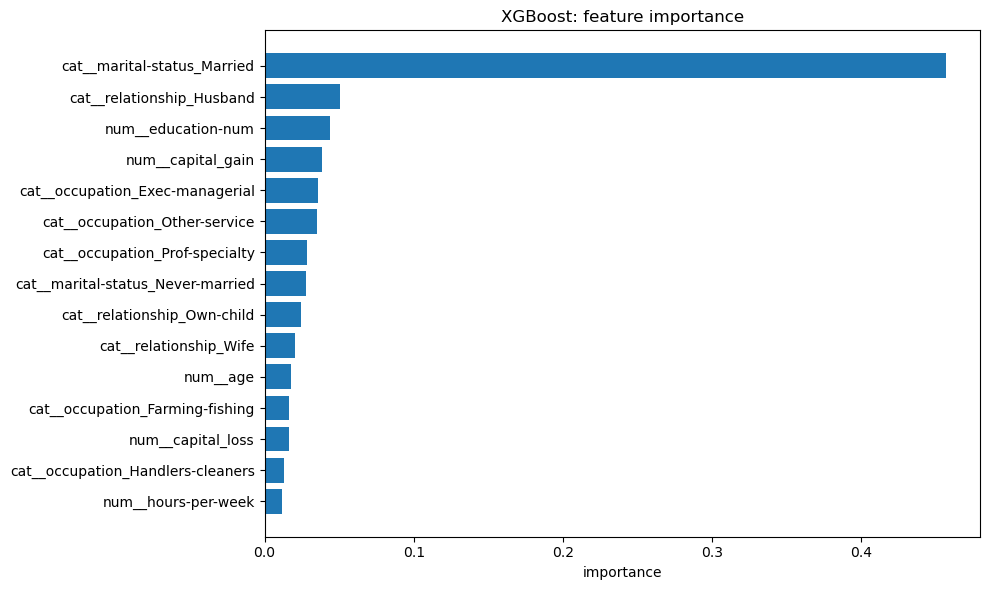

In [74]:
# feature importance
feature_names = Best_XGB.named_steps["preprocess"].get_feature_names_out()
importances = Best_XGB.named_steps["model"].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values()
top_n = 15

plt.figure(figsize=(10, 6))
plt.barh(fi.index[-top_n:], fi.values[-top_n:])
plt.title("XGBoost: feature importance")
plt.xlabel("importance")
plt.tight_layout()
plt.show()


### Ważność zmiennych

Wykres wskazuje, że zdecydowanie najważniejszą cechą w modelu jest zmienna **cat__marital-status_Married**, której udział w ważności znacząco przewyższa pozostałe predyktory. W dalszej kolejności pojawiają się cechy związane z sytuacją rodzinną (**cat__relationship_Husband**) oraz kapitałem i edukacją (**num__education-num**, **num__capital_gain**), co jest spójne z obserwacjami z EDA. Pozostałe zmienne mają wyraźnie mniejszy wkład, pełniąc głównie rolę uzupełniającą w poprawie jakości predykcji.


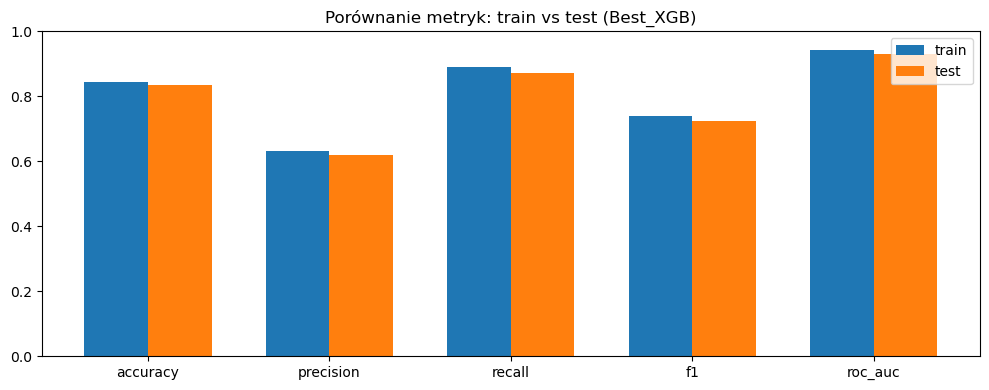

In [75]:
y_pred_tr = Best_XGB.predict(X_train)
y_proba_tr = Best_XGB.predict_proba(X_train)[:, 1]

y_pred_te = Best_XGB.predict(X_test)
y_proba_te = Best_XGB.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": (accuracy_score, False),
    "precision": (precision_score, False),
    "recall": (recall_score, False),
    "f1": (f1_score, False),
    "roc_auc": (roc_auc_score, True),
}

train_vals, test_vals, names = [], [], []
for name, (fn, needs_proba) in metrics.items():
    names.append(name)
    if needs_proba:
        train_vals.append(fn(y_train, y_proba_tr))
        test_vals.append(fn(y_test, y_proba_te))
    else:
        train_vals.append(fn(y_train, y_pred_tr))
        test_vals.append(fn(y_test, y_pred_te))

x = np.arange(len(names))
w = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - w/2, train_vals, width=w, label="train")
plt.bar(x + w/2, test_vals, width=w, label="test")
plt.xticks(x, names)
plt.ylim(0, 1)
plt.title("Porównanie metryk: train vs test (Best_XGB)")
plt.legend()
plt.tight_layout()
plt.show()


,accuracy,precision,recall,f1
model,,,,
logistic regression,0.803,0.572,0.846,0.682
random forest,0.817,0.591,0.870,0.704
xgboost,0.835,0.621,0.873,0.725


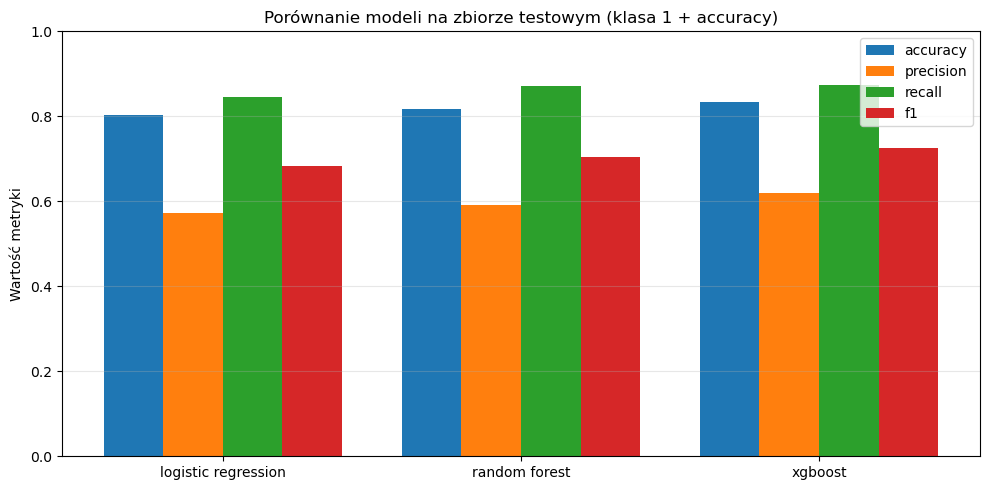

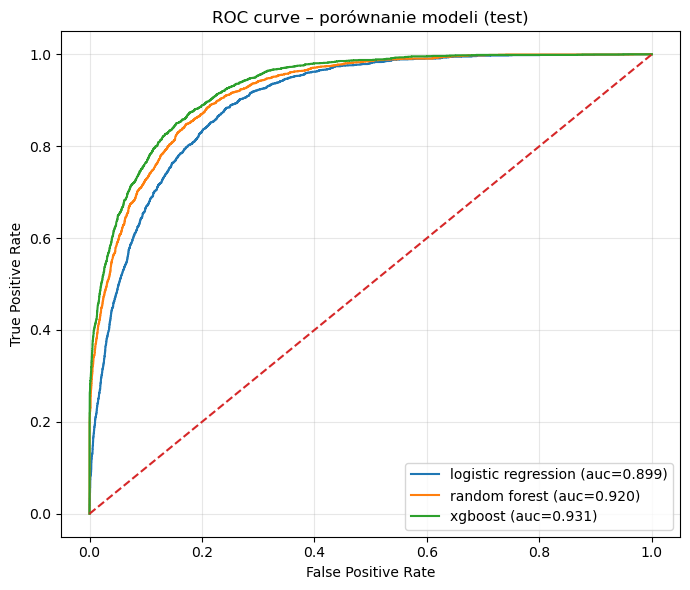

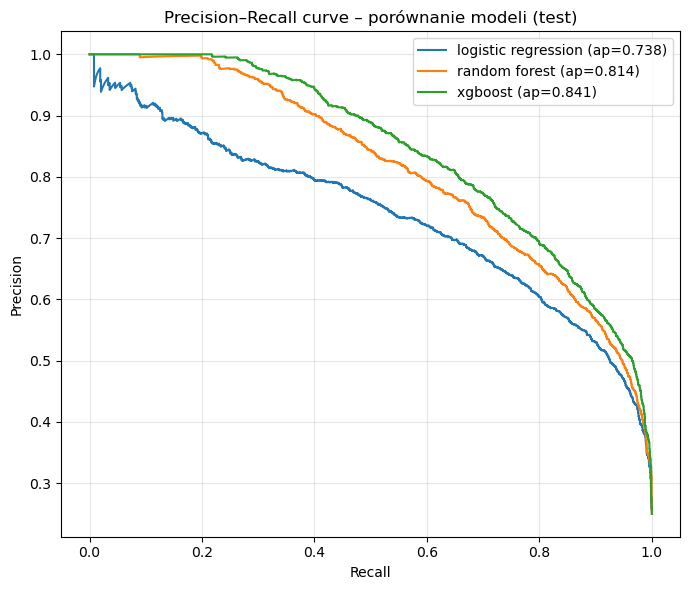

In [76]:
# =========================
# 1) Predykcje + metryki
# =========================
def policz_metryki(y_true, y_pred, nazwa_modelu):
    return {
        "model": nazwa_modelu,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label=1),
        "recall": recall_score(y_true, y_pred, pos_label=1),
        "f1": f1_score(y_true, y_pred, pos_label=1),
    }

y_pred_lr  = best_model_lr.predict(X_test)
y_prob_lr  = best_model_lr.predict_proba(X_test)[:, 1]

y_pred_rf  = best_rf.predict(X_test)
y_prob_rf  = best_rf.predict_proba(X_test)[:, 1]

y_pred_xgb = Best_XGB.predict(X_test)
y_prob_xgb = Best_XGB.predict_proba(X_test)[:, 1]

wyniki = pd.DataFrame([
    policz_metryki(y_test, y_pred_lr,  "logistic regression"),
    policz_metryki(y_test, y_pred_rf,  "random forest"),
    policz_metryki(y_test, y_pred_xgb, "xgboost"),
]).set_index("model")

display(wyniki.round(3))

# =========================
# 2) Wykres: porównanie metryk
# =========================
metryki = ["accuracy", "precision", "recall", "f1"]

plt.figure(figsize=(10, 5))
x = np.arange(len(wyniki.index))
szer = 0.2

for i, m in enumerate(metryki):
    plt.bar(x + (i - 1.5)*szer, wyniki[m].values, width=szer, label=m)

plt.xticks(x, wyniki.index, rotation=0)
plt.ylim(0, 1)
plt.ylabel("Wartość metryki")
plt.title("Porównanie modeli na zbiorze testowym (klasa 1 + accuracy)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# 3) (Opcjonalnie) ROC curve – porównanie po prawdopodobieństwach
# =========================
modele_prob = {
    "logistic regression": y_prob_lr,
    "random forest": y_prob_rf,
    "xgboost": y_prob_xgb
}

plt.figure(figsize=(7, 6))
for nazwa, y_prob in modele_prob.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{nazwa} (auc={auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – porównanie modeli (test)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# 4) (Opcjonalnie) Precision–Recall curve 
# =========================
plt.figure(figsize=(7, 6))
for nazwa, y_prob in modele_prob.items():
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(rec, prec, label=f"{nazwa} (ap={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve – porównanie modeli (test)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Wnioski końcowe (porównanie modeli)

Na zbiorze testowym najlepsze wyniki uzyskał **XGBoost**, osiągając najwyższą wartość **f1 = 0.725** oraz jednocześnie najwyższą **accuracy = 0.835**. Oznacza to najbardziej korzystny kompromis między **precision** i **recall** dla klasy 1, a więc najlepszą jakość klasyfikacji w ujęciu przyjętej metryki głównej.

Drugie miejsce zajął **Random Forest** (**f1 = 0.704**). Model ten cechuje się bardzo wysokim **recall = 0.870**, jednak nieco niższa **precision = 0.591** w porównaniu do XGBoost obniża wartość f1, co wskazuje na większą liczbę błędnych wskazań klasy 1.

Najniższe wyniki odnotowano dla **logistic regression** (**f1 = 0.682**). Pomimo relatywnie wysokiego **recall = 0.846**, niższa **precision = 0.572** ogranicza wartość f1, co sugeruje słabszą równowagę między wykrywalnością klasy 1 a liczbą fałszywych alarmów. W konsekwencji jako model końcowy najbardziej uzasadniony jest wybór **XGBoost**.
